# Phase 2: Model Explainability with SHAP

## Objective
Understand **why** the model assigns each risk score. Critical for:
- **Regulatory compliance** — Banks must explain model decisions (SR 11-7, Basel III)
- **Trust** — Portfolio managers need to understand risk drivers
- **Debugging** — Verify the model uses sensible signals, not artifacts

## SHAP (SHapley Additive exPlanations)
SHAP values decompose each prediction into the contribution of each feature. For example:
- Base risk = 0.30 (average)
- Volatility_21d pushed it +0.15 (high volatility → more risk)
- RSI pushed it -0.05 (oversold → slightly less risk)
- Final prediction = 0.40

## Sections
1. Load model and data from Phase 1
2. Compute SHAP values
3. Global feature importance (SHAP vs Gain)
4. SHAP summary plot (beeswarm)
5. Per-stock waterfall explanations
6. Feature dependence plots
7. Export SHAP explanations for app integration

In [16]:
# ============================================================
# 1. IMPORTS & LOAD MODEL
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import json
import os
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Load saved model and metadata
MODEL_DIR = os.path.join('..', 'backend', 'models')

model = joblib.load(os.path.join(MODEL_DIR, 'risk_classifier.joblib'))
feature_cols = joblib.load(os.path.join(MODEL_DIR, 'feature_list.joblib'))

with open(os.path.join(MODEL_DIR, 'model_metadata.json')) as f:
    metadata = json.load(f)

print(f'Model: {metadata["model_name"]}')
print(f'AUC-ROC: {metadata["auc_roc"]:.4f}')
print(f'Features: {metadata["n_features"]}')
print(f'Target: {metadata["target"]}')

Model: XGBoost_v3_volatility
AUC-ROC: 0.7286
Features: 34
Target: high_volatility_21d (top 30%)


In [17]:
# ============================================================
# Rebuild test data (same pipeline as Phase 1)
# ============================================================

import yfinance as yf
from datetime import datetime

SYMBOLS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'NFLX',
    'ADBE', 'CRM', 'ORCL', 'CSCO', 'INTC', 'AMD', 'QCOM', 'TXN',
    'AVGO', 'INTU', 'AMAT', 'LRCX', 'MU', 'KLAC', 'SNPS', 'CDNS',
    'MCHP', 'MRVL', 'NXPI', 'ADI', 'SWKS', 'QRVO', 'UBER', 'ABNB',
    'SNOW', 'ZM', 'DOCU', 'SHOP', 'COIN', 'RBLX', 'DDOG', 'NET',
    'CRWD', 'ZS', 'PANW', 'FTNT', 'OKTA', 'NOW', 'WDAY', 'TEAM',
]

ALL_TICKERS = SYMBOLS + ['SPY']

print('Downloading data...')
raw_data = yf.download(ALL_TICKERS, period='5y', interval='1d', group_by='ticker', auto_adjust=True)

records = []
for symbol in ALL_TICKERS:
    try:
        df = raw_data[symbol].dropna(subset=['Close']).reset_index()
        df['symbol'] = symbol
        df.columns = [c.lower() if c != 'symbol' else c for c in df.columns]
        records.append(df[['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']])
    except:
        pass

data = pd.concat(records, ignore_index=True)
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['symbol', 'date']).reset_index(drop=True)

spy_data = data[data['symbol'] == 'SPY'][['date', 'close']].rename(columns={'close': 'spy_close'})
spy_data['spy_return'] = spy_data['spy_close'].pct_change()

stock_data = data[data['symbol'] != 'SPY'].copy()
stock_data = stock_data.merge(spy_data[['date', 'spy_return']], on='date', how='left')

print(f'Data loaded: {len(stock_data):,} rows, {stock_data.symbol.nunique()} stocks')

[*********************100%***********************]  49 of 49 completed


Data loaded: 60,188 rows, 48 stocks


In [18]:
# Feature engineering (same as Phase 1)

def compute_all_features(df):
    """Compute all 34 features for a single stock."""
    df = df.sort_values('date').copy()
    close = df['close']
    high = df['high']
    low = df['low']
    volume = df['volume']
    
    df['daily_return'] = close.pct_change()
    df['volatility_21d'] = df['daily_return'].rolling(21).std() * np.sqrt(252)
    df['volatility_63d'] = df['daily_return'].rolling(63).std() * np.sqrt(252)
    df['return_5d'] = close.pct_change(5)
    df['return_10d'] = close.pct_change(10)
    df['return_21d'] = close.pct_change(21)
    df['return_63d'] = close.pct_change(63)
    
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-10)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    ema_12 = close.ewm(span=12, adjust=False).mean()
    ema_26 = close.ewm(span=26, adjust=False).mean()
    df['macd_line'] = ema_12 - ema_26
    df['macd_signal'] = df['macd_line'].ewm(span=9, adjust=False).mean()
    df['macd_histogram'] = df['macd_line'] - df['macd_signal']
    
    sma_20 = close.rolling(20).mean()
    std_20 = close.rolling(20).std()
    bb_upper = sma_20 + 2 * std_20
    bb_lower = sma_20 - 2 * std_20
    df['bb_width'] = (bb_upper - bb_lower) / (sma_20 + 1e-10)
    df['bb_position'] = (close - bb_lower) / (bb_upper - bb_lower + 1e-10)
    
    df['volume_ratio'] = volume / (volume.rolling(50).mean() + 1e-10)
    
    rolling_max = close.rolling(63, min_periods=1).max()
    drawdown = (close - rolling_max) / (rolling_max + 1e-10)
    df['max_drawdown_63d'] = drawdown.rolling(63, min_periods=1).min()
    
    cov = df['daily_return'].rolling(63).cov(df['spy_return'])
    var = df['spy_return'].rolling(63).var()
    df['beta_63d'] = cov / (var + 1e-10)
    
    high_252 = high.rolling(252, min_periods=63).max()
    low_252 = low.rolling(252, min_periods=63).min()
    df['dist_from_52w_high'] = (close - high_252) / (high_252 + 1e-10)
    df['dist_from_52w_low'] = (close - low_252) / (low_252 + 1e-10)
    
    tr = pd.DataFrame({
        'hl': high - low,
        'hc': abs(high - close.shift(1)),
        'lc': abs(low - close.shift(1))
    }).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean() / (close + 1e-10)
    
    # v2 features
    df['vol_change'] = df['volatility_21d'] - df['volatility_63d']
    df['momentum_reversal'] = df['return_5d'] - df['return_21d']
    df['return_vol_adj'] = df['return_21d'] / (df['volatility_21d'] + 1e-10)
    df['rsi_overbought'] = (df['rsi_14'] > 70).astype(int)
    df['rsi_oversold'] = (df['rsi_14'] < 30).astype(int)
    df['down_day'] = (df['daily_return'] < 0).astype(int)
    df['down_volume_ratio'] = (df['down_day'] * df['volume']).rolling(21).sum() / (df['volume'].rolling(21).sum() + 1e-10)
    sma_10 = close.rolling(10).mean()
    sma_50 = close.rolling(50).mean()
    df['sma_cross'] = (sma_10 - sma_50) / (sma_50 + 1e-10)
    df['consec_down'] = df['daily_return'].lt(0).rolling(10).sum()
    df['beta_vol_interaction'] = df['beta_63d'] * df['volatility_21d']
    
    return df

print('Computing features...')
all_dfs = []
for symbol in stock_data['symbol'].unique():
    sdf = stock_data[stock_data['symbol'] == symbol].copy()
    sdf = compute_all_features(sdf)
    all_dfs.append(sdf)

featured = pd.concat(all_dfs, ignore_index=True)

# Cross-sectional ranks
for feat in ['volatility_21d', 'return_21d', 'beta_63d', 'volume_ratio']:
    featured[f'{feat}_rank'] = featured.groupby('date')[feat].rank(pct=True)

# Market regime
spy_vol = spy_data.copy()
spy_vol['spy_vol_21d'] = spy_vol['spy_close'].pct_change().rolling(21).std() * np.sqrt(252)
spy_vol['spy_return_21d'] = spy_vol['spy_close'].pct_change(21)
spy_vol['high_vol_regime'] = (spy_vol['spy_vol_21d'] > spy_vol['spy_vol_21d'].rolling(252).quantile(0.75)).astype(int)

featured = featured.merge(
    spy_vol[['date', 'spy_vol_21d', 'spy_return_21d', 'high_vol_regime']],
    on='date', how='left'
)

featured = featured.dropna(subset=feature_cols)

# Get latest features per stock (current risk assessment)
latest = featured.sort_values('date').groupby('symbol').last()[feature_cols]
print(f'Latest features shape: {latest.shape}')
print(f'Stocks: {list(latest.index)}')

Computing features...
Latest features shape: (48, 34)
Stocks: ['AAPL', 'ABNB', 'ADBE', 'ADI', 'AMAT', 'AMD', 'AMZN', 'AVGO', 'CDNS', 'COIN', 'CRM', 'CRWD', 'CSCO', 'DDOG', 'DOCU', 'FTNT', 'GOOGL', 'INTC', 'INTU', 'KLAC', 'LRCX', 'MCHP', 'META', 'MRVL', 'MSFT', 'MU', 'NET', 'NFLX', 'NOW', 'NVDA', 'NXPI', 'OKTA', 'ORCL', 'PANW', 'QCOM', 'QRVO', 'RBLX', 'SHOP', 'SNOW', 'SNPS', 'SWKS', 'TEAM', 'TSLA', 'TXN', 'UBER', 'WDAY', 'ZM', 'ZS']


---
## 2. Compute SHAP Values

In [19]:
# Use TreeExplainer (exact, fast for tree-based models)
print('Computing SHAP values...')
explainer = shap.TreeExplainer(model)

# SHAP values for the latest snapshot of all stocks
shap_values_latest = explainer.shap_values(latest)

# Also compute on a larger sample for global analysis
# Use recent 6 months of data
recent_data = featured[featured['date'] >= featured['date'].max() - pd.Timedelta(days=180)]
recent_features = recent_data[feature_cols].dropna()

# Sample for performance (SHAP on full set can be slow)
sample_size = min(5000, len(recent_features))
sample_features = recent_features.sample(n=sample_size, random_state=42)

shap_values_sample = explainer.shap_values(sample_features)

print(f'SHAP computed for {len(latest)} stocks (current) + {sample_size} sample rows (global)')
print(f'Expected value (base risk): {explainer.expected_value:.4f}')

Computing SHAP values...
SHAP computed for 48 stocks (current) + 5000 sample rows (global)
Expected value (base risk): 0.0241


---
## 3. Global Feature Importance: SHAP vs Gain

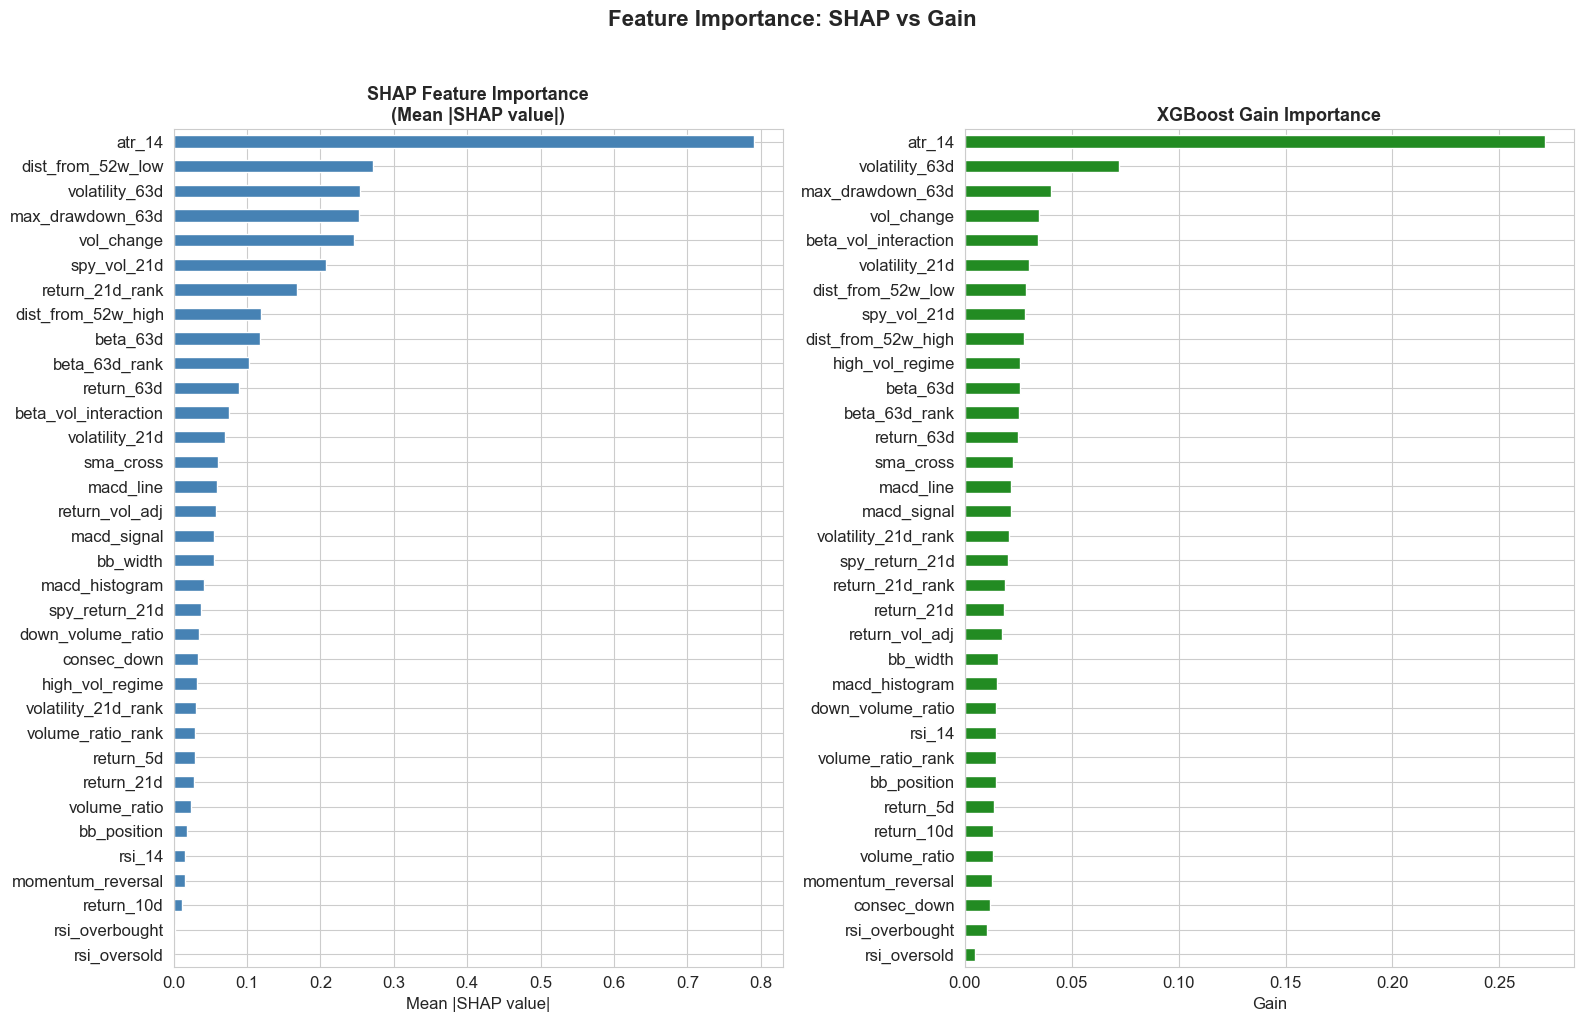

Rank correlation between SHAP and Gain importance: 0.882 (p=0.0000)


In [20]:
# Compare SHAP importance vs XGBoost gain-based importance
shap_importance = pd.Series(
    np.abs(shap_values_sample).mean(axis=0),
    index=feature_cols
).sort_values(ascending=True)

gain_importance = pd.Series(
    model.feature_importances_,
    index=feature_cols
).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

shap_importance.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('SHAP Feature Importance\n(Mean |SHAP value|)', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Mean |SHAP value|')

gain_importance.plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('XGBoost Gain Importance', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Gain')

plt.suptitle('Feature Importance: SHAP vs Gain', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('shap_vs_gain.png', dpi=150, bbox_inches='tight')
plt.show()

# Rank correlation between the two methods
from scipy.stats import spearmanr
rho, pval = spearmanr(shap_importance.rank(), gain_importance.reindex(shap_importance.index).rank())
print(f'Rank correlation between SHAP and Gain importance: {rho:.3f} (p={pval:.4f})')

---
## 4. SHAP Summary Plot (Beeswarm)

Shows how each feature impacts predictions across all samples. Each dot is one stock-day. Color = feature value (red=high, blue=low). Position = SHAP impact on risk.

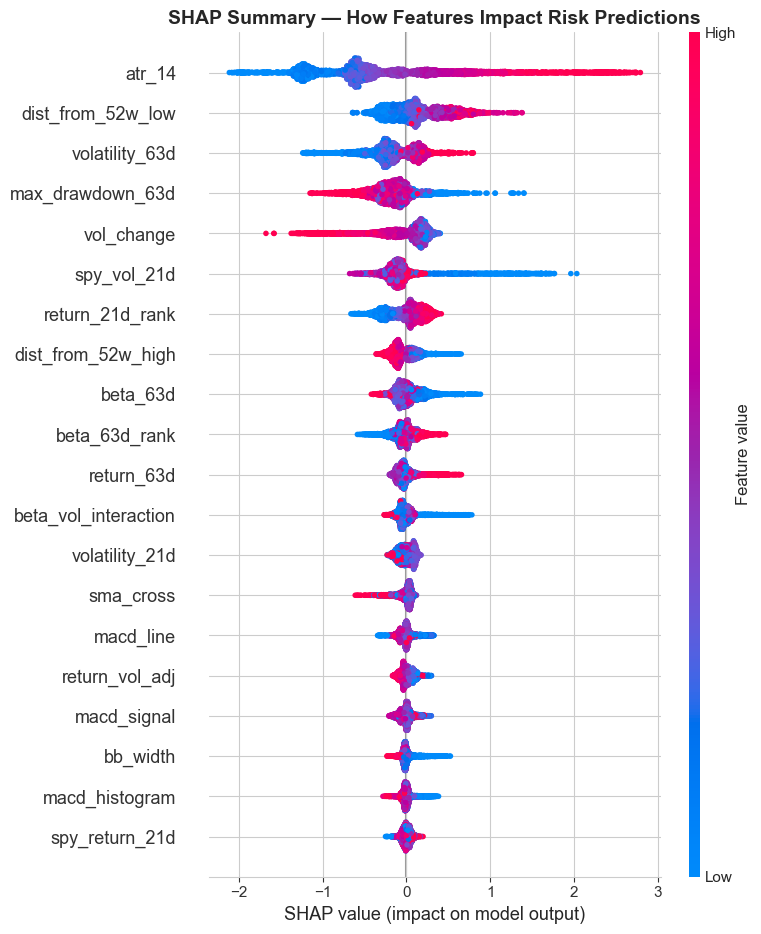

In [21]:
# Beeswarm summary plot
fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values_sample, sample_features, feature_names=feature_cols,
                  show=False, max_display=20)
plt.title('SHAP Summary — How Features Impact Risk Predictions', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('shap_summary_beeswarm.png', dpi=150, bbox_inches='tight')
plt.show()

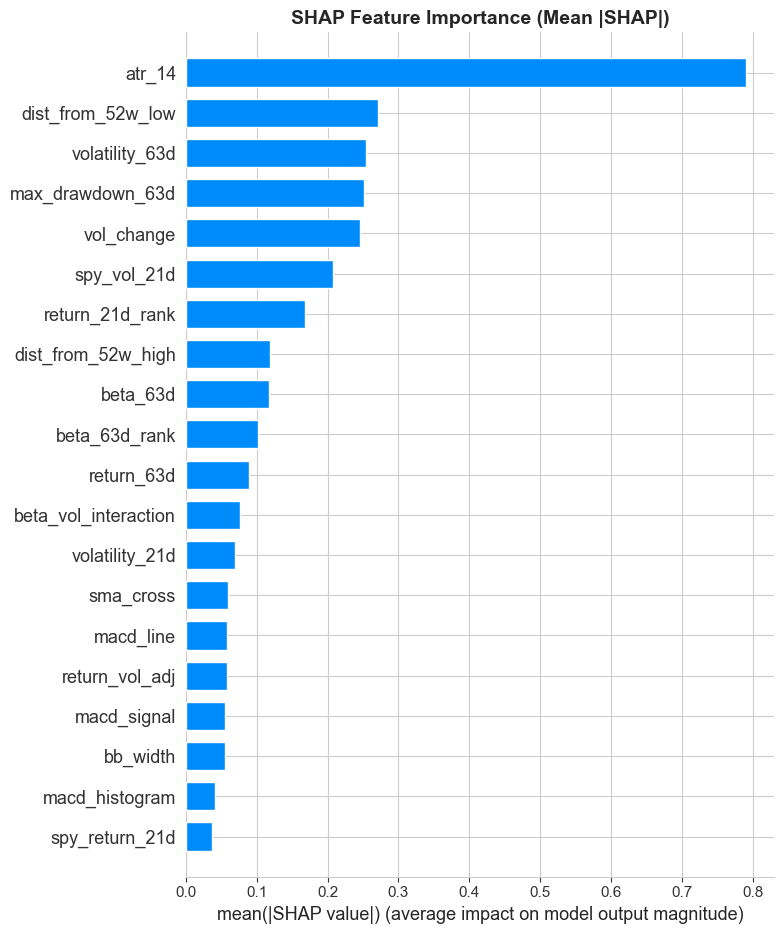

In [22]:
# Bar summary (mean absolute SHAP)
fig, ax = plt.subplots(figsize=(10, 10))
shap.summary_plot(shap_values_sample, sample_features, feature_names=feature_cols,
                  plot_type='bar', show=False, max_display=20)
plt.title('SHAP Feature Importance (Mean |SHAP|)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('shap_summary_bar.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Per-Stock Waterfall Explanations

For each stock, show exactly WHY it got its risk score — which features pushed risk up vs down.

In [23]:
# Current risk scores
risk_probs = model.predict_proba(latest)[:, 1]
risk_df = pd.DataFrame({
    'symbol': latest.index,
    'risk_probability': risk_probs
}).sort_values('risk_probability', ascending=False)

print('Current Risk Scores (top 10 highest risk):')
print(risk_df.head(10).to_string(index=False))
print(f'\nLowest 5:')
print(risk_df.tail(5).to_string(index=False))

Current Risk Scores (top 10 highest risk):
symbol  risk_probability
    MU          0.978917
  COIN          0.975255
  SNOW          0.934628
  LRCX          0.930060
  RBLX          0.925600
  AMAT          0.913252
   NOW          0.896015
  ORCL          0.896013
  TEAM          0.889042
    ZS          0.881041

Lowest 5:
symbol  risk_probability
   TXN          0.221781
  META          0.197206
  MSFT          0.146495
  CSCO          0.121962
  AAPL          0.049579


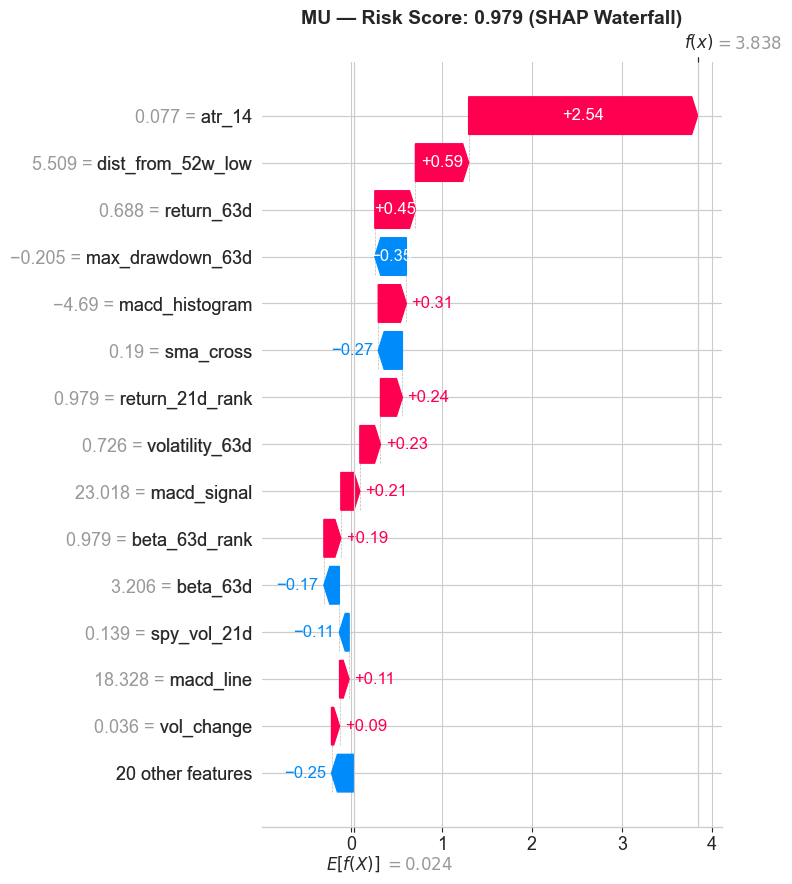

MU: Risk = 0.979



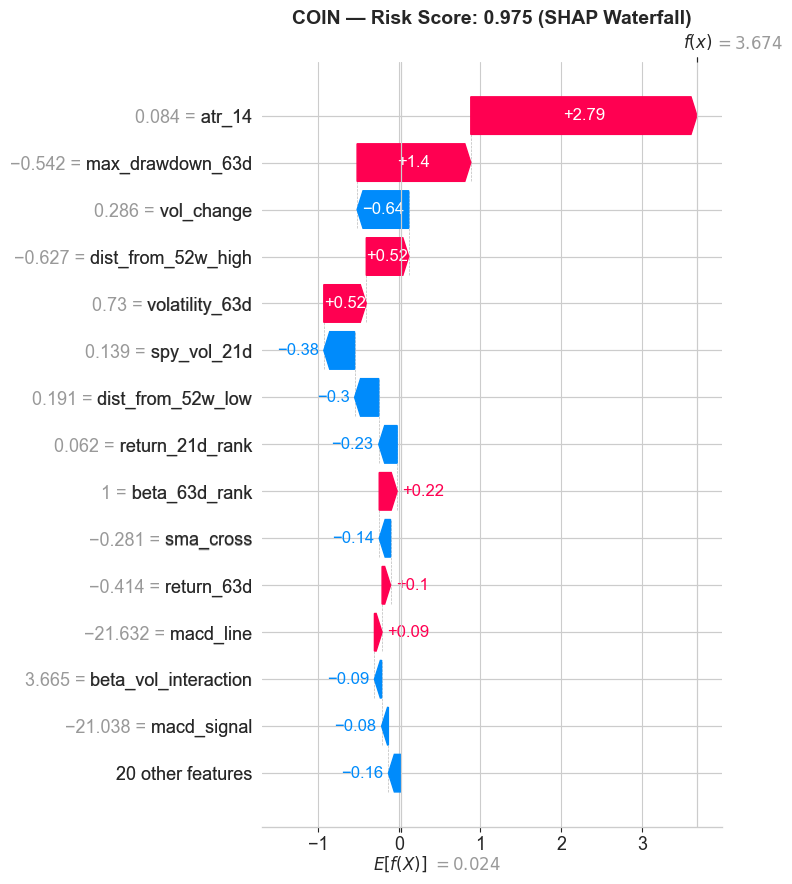

COIN: Risk = 0.975



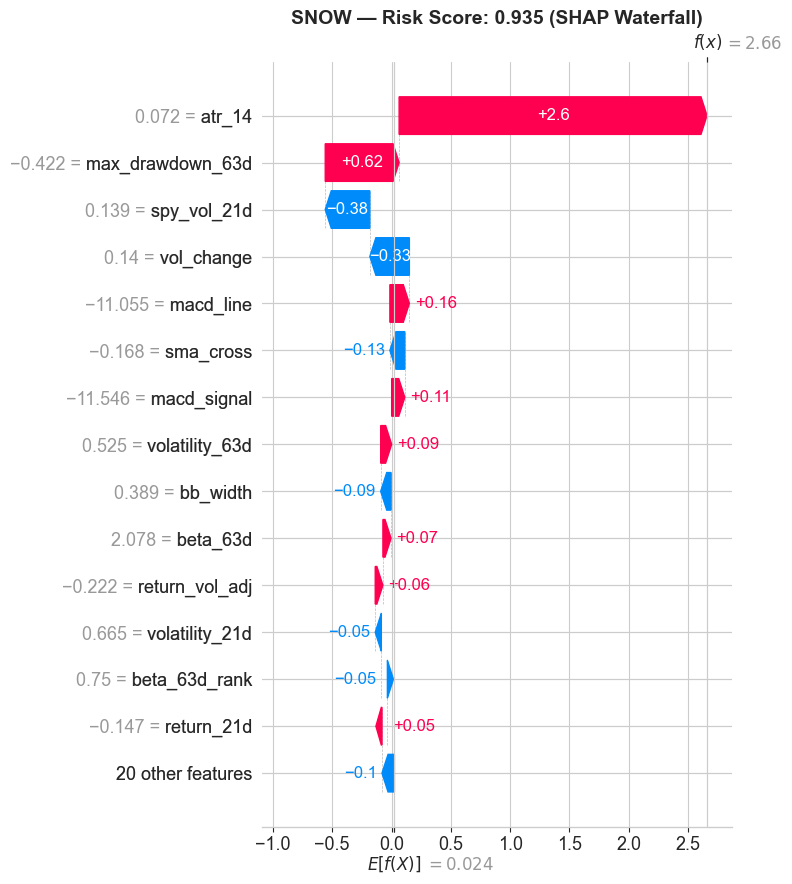

SNOW: Risk = 0.935



In [24]:
# Waterfall plot for top 3 highest risk stocks
top_risk = risk_df.head(3)['symbol'].tolist()

for symbol in top_risk:
    idx = list(latest.index).index(symbol)
    risk_prob = risk_probs[idx]
    
    shap_explanation = shap.Explanation(
        values=shap_values_latest[idx],
        base_values=explainer.expected_value,
        data=latest.iloc[idx].values,
        feature_names=feature_cols
    )
    
    fig, ax = plt.subplots(figsize=(10, 8))
    shap.plots.waterfall(shap_explanation, max_display=15, show=False)
    plt.title(f'{symbol} — Risk Score: {risk_prob:.3f} (SHAP Waterfall)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'shap_waterfall_{symbol}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'{symbol}: Risk = {risk_prob:.3f}')
    print()

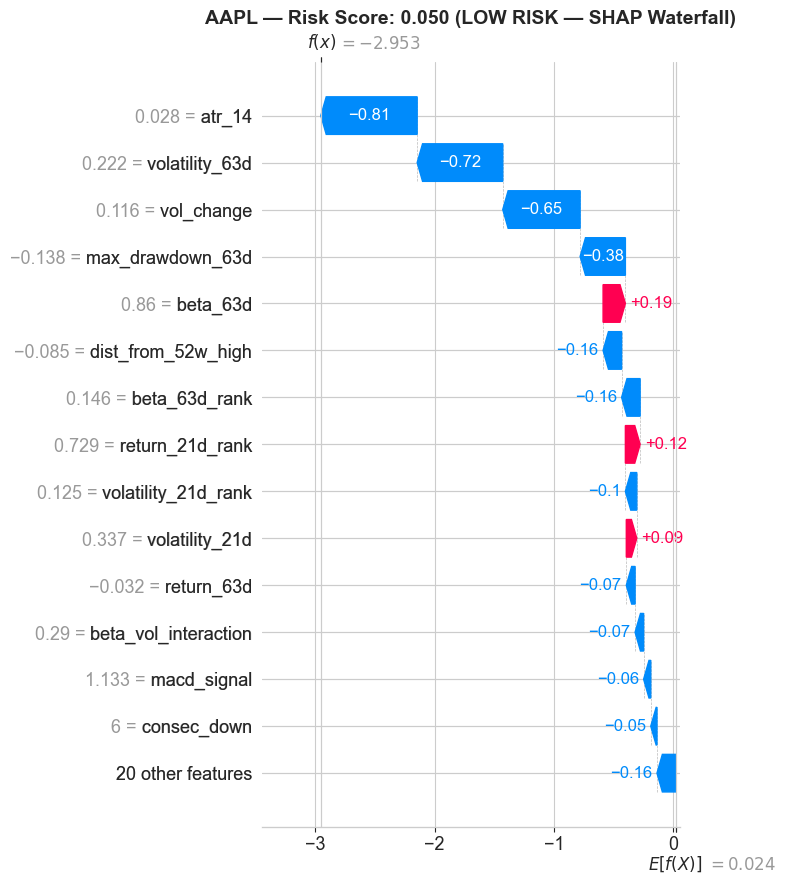

In [25]:
# Waterfall for a LOW risk stock for contrast
low_risk_symbol = risk_df.tail(1)['symbol'].values[0]
idx = list(latest.index).index(low_risk_symbol)
risk_prob = risk_probs[idx]

shap_explanation = shap.Explanation(
    values=shap_values_latest[idx],
    base_values=explainer.expected_value,
    data=latest.iloc[idx].values,
    feature_names=feature_cols
)

fig, ax = plt.subplots(figsize=(10, 8))
shap.plots.waterfall(shap_explanation, max_display=15, show=False)
plt.title(f'{low_risk_symbol} — Risk Score: {risk_prob:.3f} (LOW RISK — SHAP Waterfall)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig(f'shap_waterfall_{low_risk_symbol}_low.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Feature Dependence Plots

How does a feature's value affect its SHAP contribution? Shows non-linear relationships the model learned.

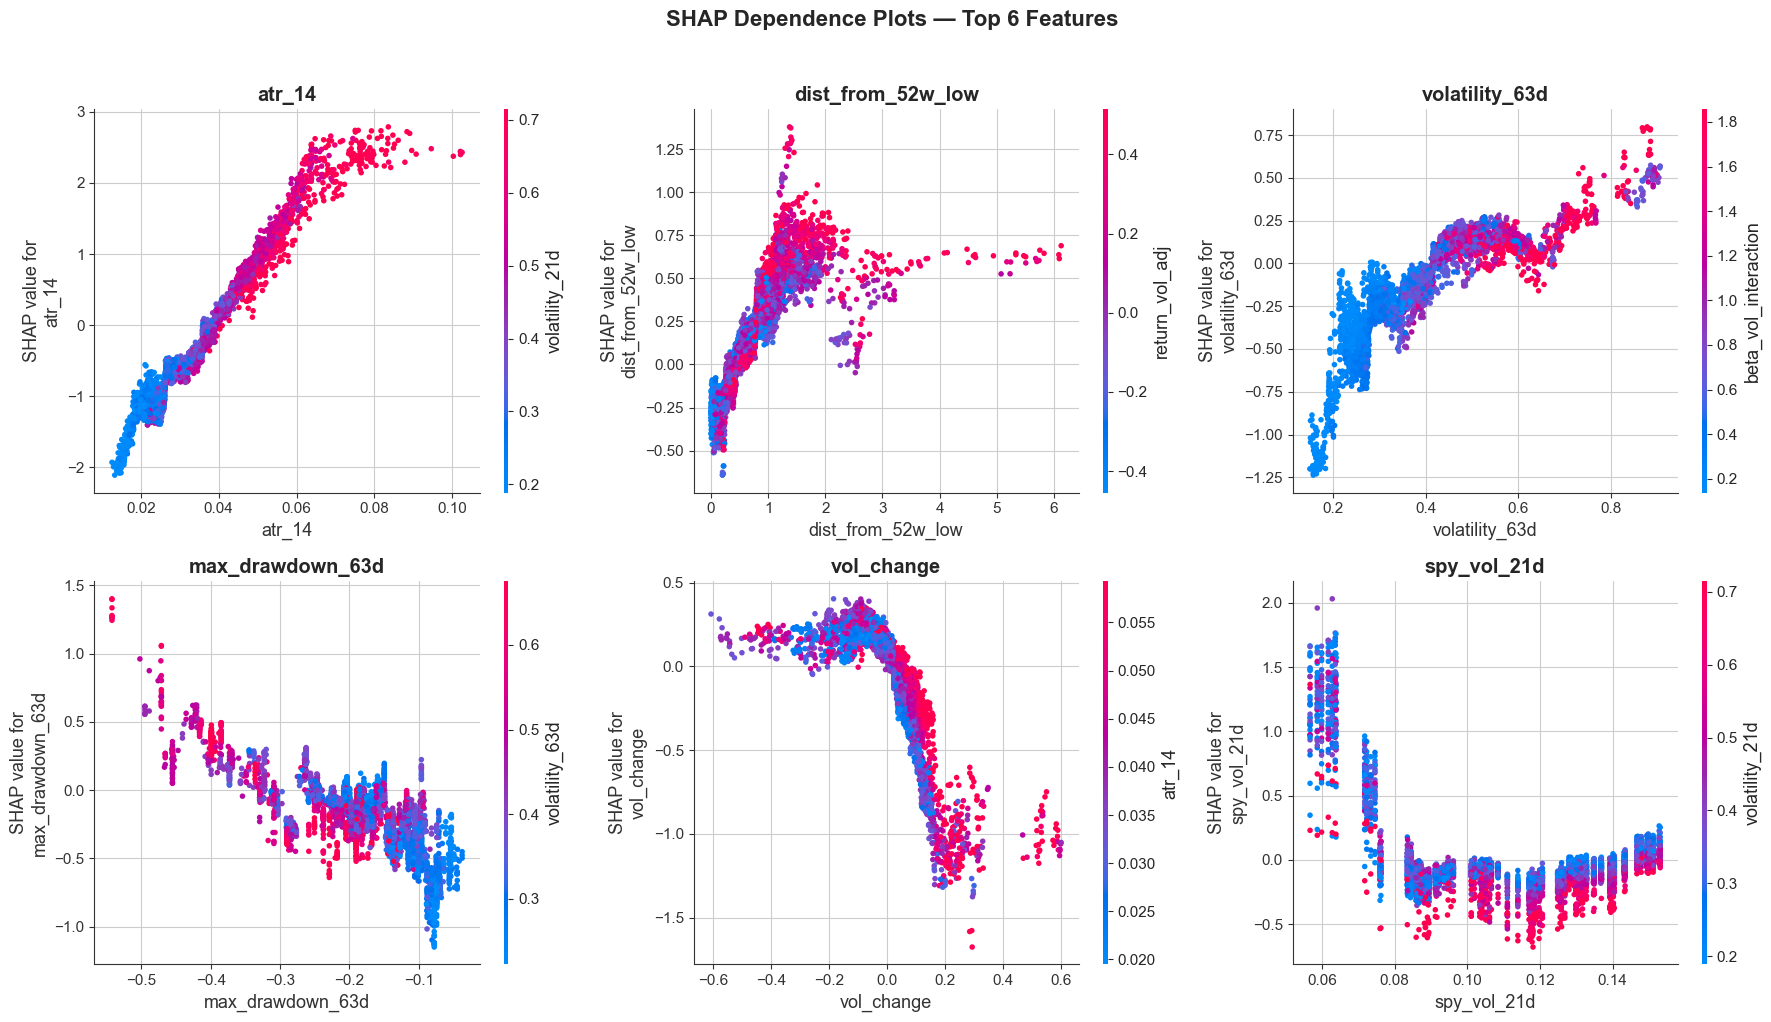

In [26]:
# Top 6 features dependence plots
top_6 = shap_importance.tail(6).index.tolist()[::-1]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, feat in enumerate(top_6):
    ax = axes[i // 3, i % 3]
    feat_idx = feature_cols.index(feat)
    shap.dependence_plot(
        feat_idx, shap_values_sample, sample_features,
        feature_names=feature_cols, ax=ax, show=False
    )
    ax.set_title(feat, fontweight='bold')

plt.suptitle('SHAP Dependence Plots — Top 6 Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 7. All Stocks SHAP Heatmap

Show SHAP values for all stocks at once — which features are driving risk for each stock right now.

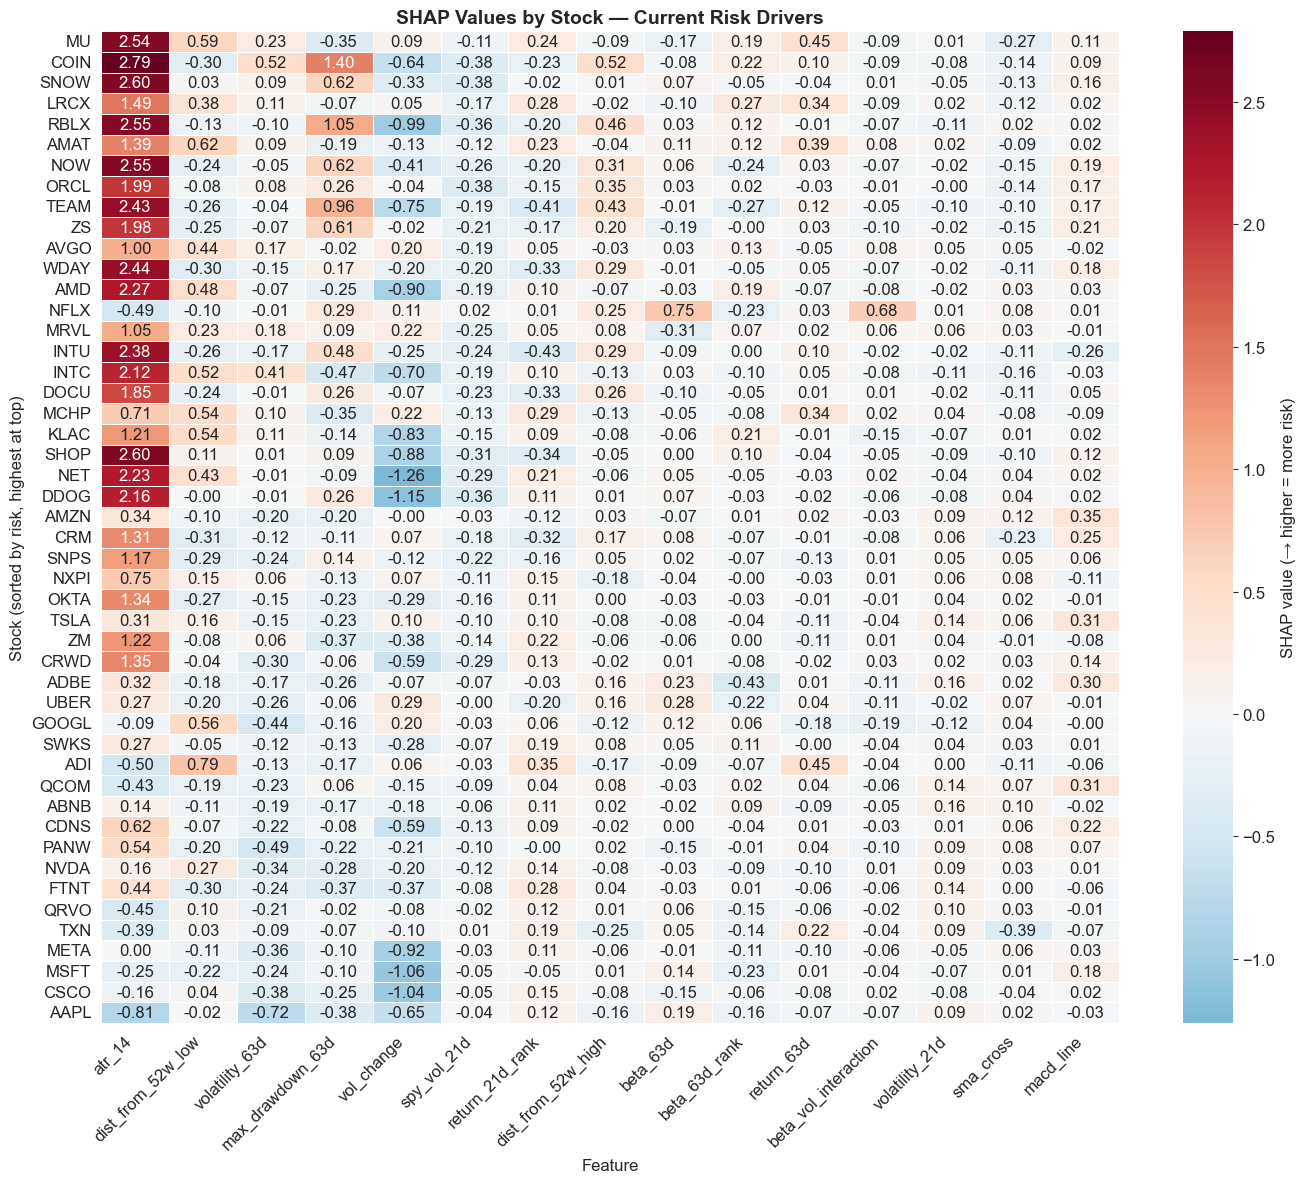

In [27]:
# SHAP heatmap: stocks x features
shap_df = pd.DataFrame(shap_values_latest, index=latest.index, columns=feature_cols)

# Sort stocks by risk score, show top 15 features by importance
top_15_feats = shap_importance.tail(15).index.tolist()[::-1]
sorted_stocks = risk_df['symbol'].tolist()

heatmap_data = shap_df.loc[sorted_stocks, top_15_feats]

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            ax=ax, linewidths=0.5, cbar_kws={'label': 'SHAP value (→ higher = more risk)'})
ax.set_title('SHAP Values by Stock — Current Risk Drivers', fontweight='bold', fontsize=14)
ax.set_ylabel('Stock (sorted by risk, highest at top)')
ax.set_xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('shap_heatmap_all_stocks.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Force Plot — Interactive Explanation

In [28]:
# Initialize JS for force plots in notebook
shap.initjs()

# Force plot for highest risk stock
top_symbol = risk_df.iloc[0]['symbol']
top_idx = list(latest.index).index(top_symbol)

print(f'Force plot for {top_symbol} (highest risk: {risk_probs[top_idx]:.3f})')
shap.force_plot(
    explainer.expected_value,
    shap_values_latest[top_idx],
    latest.iloc[top_idx],
    feature_names=feature_cols
)

Force plot for MU (highest risk: 0.979)


---
## 9. Export SHAP Explanations for App Integration

In [29]:
# Generate explanation strings for each stock (for the AI assistant and dashboard)
explanations = {}

for symbol in latest.index:
    idx = list(latest.index).index(symbol)
    risk_prob = risk_probs[idx]
    shap_vals = shap_values_latest[idx]
    
    # Top 3 features pushing risk UP
    feat_shap = sorted(zip(feature_cols, shap_vals), key=lambda x: x[1], reverse=True)
    top_up = [(f, v) for f, v in feat_shap if v > 0][:3]
    
    # Top 3 features pushing risk DOWN
    top_down = [(f, v) for f, v in feat_shap if v < 0][-3:]
    
    # Build explanation string
    up_str = ', '.join([f'{f} (+{v:.3f})' for f, v in top_up]) if top_up else 'none'
    down_str = ', '.join([f'{f} ({v:.3f})' for f, v in top_down]) if top_down else 'none'
    
    explanations[symbol] = {
        'risk_probability': float(risk_prob),
        'risk_level': 'High' if risk_prob > 0.6 else 'Medium' if risk_prob > 0.3 else 'Low',
        'shap_base': float(explainer.expected_value),
        'risk_drivers_up': up_str,
        'risk_drivers_down': down_str,
        'top_features': {f: float(v) for f, v in feat_shap[:5]},
    }

# Save to JSON for app
explanations_path = os.path.join(MODEL_DIR, 'shap_explanations.json')
with open(explanations_path, 'w') as f:
    json.dump(explanations, f, indent=2)

print(f'✓ SHAP explanations saved: {explanations_path}')
print(f'  {len(explanations)} stocks explained')

# Show a few examples
for sym in risk_df.head(3)['symbol'].tolist():
    e = explanations[sym]
    print(f'\n{sym} (Risk: {e["risk_probability"]:.3f} - {e["risk_level"]})')
    print(f'  ↑ Pushing risk UP:   {e["risk_drivers_up"]}')
    print(f'  ↓ Pushing risk DOWN: {e["risk_drivers_down"]}')

✓ SHAP explanations saved: ..\backend\models\shap_explanations.json
  48 stocks explained

MU (Risk: 0.979 - High)
  ↑ Pushing risk UP:   atr_14 (+2.539), dist_from_52w_low (+0.590), return_63d (+0.450)
  ↓ Pushing risk DOWN: beta_63d (-0.171), sma_cross (-0.268), max_drawdown_63d (-0.349)

COIN (Risk: 0.975 - High)
  ↑ Pushing risk UP:   atr_14 (+2.789), max_drawdown_63d (+1.402), dist_from_52w_high (+0.524)
  ↓ Pushing risk DOWN: dist_from_52w_low (-0.298), spy_vol_21d (-0.380), vol_change (-0.637)

SNOW (Risk: 0.935 - High)
  ↑ Pushing risk UP:   atr_14 (+2.596), max_drawdown_63d (+0.623), macd_line (+0.164)
  ↓ Pushing risk DOWN: sma_cross (-0.126), vol_change (-0.333), spy_vol_21d (-0.376)


In [30]:
# Save the SHAP explainer for live use in the app
joblib.dump(explainer, os.path.join(MODEL_DIR, 'shap_explainer.joblib'))
print('✓ SHAP explainer saved for live integration')

✓ SHAP explainer saved for live integration


---
## Summary

### What We Learned
- **SHAP provides exact feature contributions** for each stock's risk score
- **Global importance** shows which features matter most across all predictions
- **Waterfall plots** explain individual stocks: "COIN is high risk because volatility (+0.12) and beta (+0.08) are elevated"
- **Dependence plots** reveal non-linear relationships (e.g., risk increases sharply when volatility exceeds a threshold)

### Files Saved
- `backend/models/shap_explanations.json` — Per-stock risk explanations (for AI assistant)
- `backend/models/shap_explainer.joblib` — Explainer object (for live SHAP computation)

### Integration Points
- **AI Assistant:** When asked "Why is COIN high risk?" → reads from shap_explanations.json
- **Dashboard:** "Explain" button per stock → shows waterfall chart
- **Alerts:** Alert explanations include SHAP-based risk drivers

### Next Steps
- **Phase 3:** Volatility forecasting (GARCH/LSTM)
- **Phase 4:** Complete EDA documentation notebook